In [45]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')


## Data Preprocessing
- Convert 'Month' column to datetime type
- Set 'Month' as index
- Handle missing values (do not remove any rows)


In [46]:
# Load the dataset
df = pd.read_csv("trendkart_sales_data.csv")

# Convert Month to datetime
df['Month'] = pd.to_datetime(df['Month'])

# Set Month as index
df.set_index('Month', inplace=True)

# Check for missing values
print("Missing values:\n", df.isnull().sum())


Missing values:
 Total_Sales           0
Promotions            0
Festive_Season        0
Online_Sales_Ratio    0
dtype: int64


as there are no missing values there is no need to do any handling with the missing data

In [47]:
df.head()

,Total_Sales,Promotions,Festive_Season,Online_Sales_Ratio
Month,,,,
2019-01-01,20745.07,0,0,0.25
2019-02-01,21442.60,0,0,0.35
2019-03-01,23869.61,0,0,0.35
2019-04-01,25734.54,0,0,0.47
2019-05-01,22846.85,1,0,0.34


## Exploratory Data Analysis (EDA)

### Plot raw sales data
To observe overall trend and seasonality.


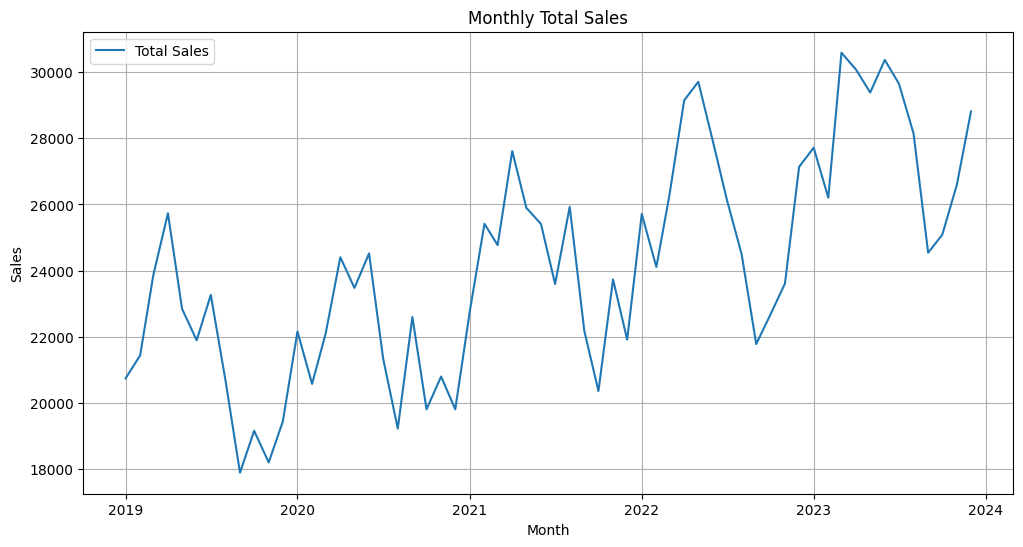

In [48]:
# Plot total sales
plt.figure(figsize=(12, 6))
plt.plot(df['Total_Sales'], label='Total Sales')
plt.title("Monthly Total Sales")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.show()


### Moving Averages
- 3-month and 12-month moving averages to smooth out noise.


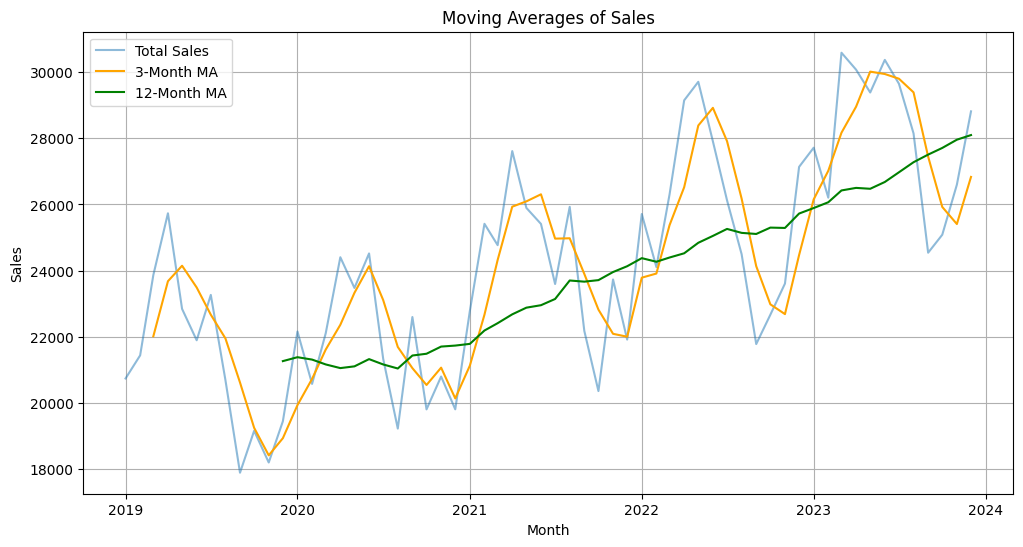

In [49]:
df['MA_3'] = df['Total_Sales'].rolling(window=3).mean()
df['MA_12'] = df['Total_Sales'].rolling(window=12).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Total_Sales'], label='Total Sales', alpha=0.5)
plt.plot(df['MA_3'], label='3-Month MA', color='orange')
plt.plot(df['MA_12'], label='12-Month MA', color='green')
plt.title("Moving Averages of Sales")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.show()


### Seasonal Decomposition
Using Seasonal-Trend decomposition using LOESS.


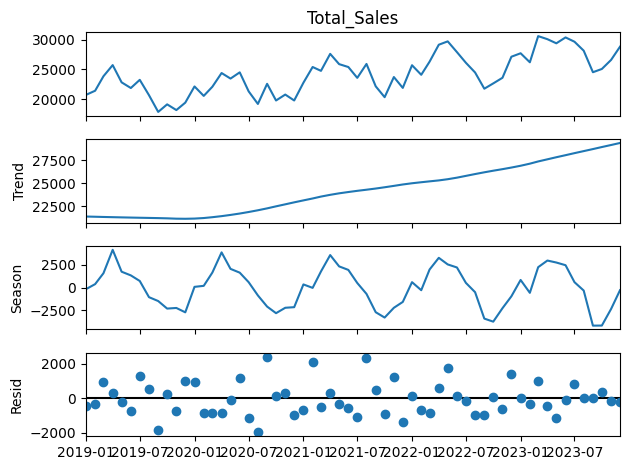

In [50]:
stl = seasonal_decompose(df['Total_Sales'], model='additive')
result.plot()
plt.show()


## Stationarity Check
Using Augmented Dickey-Fuller (ADF) Test to check for stationarity.


In [51]:
adf_result = adfuller(df['Total_Sales'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")


ADF Statistic: 0.8094226831168545
p-value: 0.9917867552700765


## Making the Series Stationary

Since the ADF test showed non-stationarity (p-value > 0.05), we apply:
- **Log transformation** to stabilize variance
- **Differencing** to remove trend

We then rerun the ADF test to confirm stationarity.


In [59]:
# Log transform the sales to stabilize variance
df['Log_Sales'] = np.log(df['Total_Sales'])

# First-order differencing to remove trend
df['Log_Sales_Diff'] = df['Log_Sales'].diff()

# Drop initial NaN after differencing
df_stationary = df.dropna(subset=['Log_Sales_Diff'])


### ADF Test on Differenced Series


In [61]:
from statsmodels.tsa.stattools import adfuller

adf_result_diff = adfuller(df_stationary['Log_Sales_Diff'])
print(f"ADF Statistic (Differenced): {adf_result_diff[0]}")
print(f"p-value (Differenced): {adf_result_diff[1]}")


ADF Statistic (Differenced): -6.998859570580166
p-value (Differenced): 7.411127327705914e-10


## Visualization of Stationary Series

We plot the transformed data (`Log_Sales_Diff`) to visually confirm the removal of trend and seasonality. The series should now fluctuate around a constant mean with no visible trend.


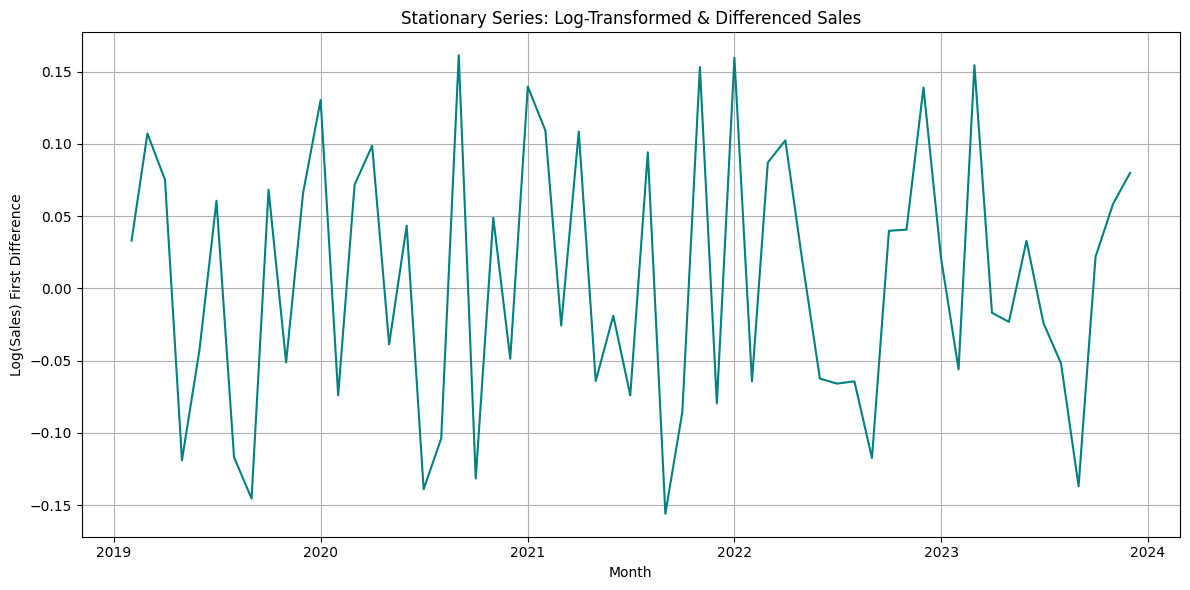

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(df_stationary['Log_Sales_Diff'], color='teal')
plt.title("Stationary Series: Log-Transformed & Differenced Sales")
plt.xlabel("Month")
plt.ylabel("Log(Sales) First Difference")
plt.grid(True)
plt.tight_layout()
plt.show()


## Model Selection and Forecasting

### Train-Test Split
- Use 80% of data for training
- 20% for testing


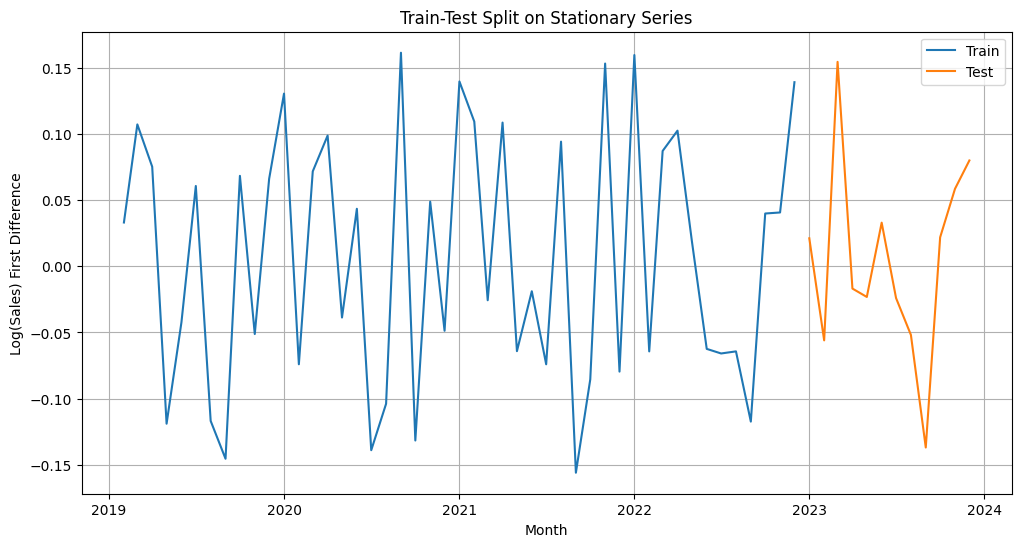

In [64]:
# Use only non-null values after transformation
df_stationary = df.dropna(subset=['Log_Sales_Diff'])

# Train-test split on stationary data
train_size = int(len(df_stationary) * 0.8)
train, test = df_stationary.iloc[:train_size], df_stationary.iloc[train_size:]

# Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(train['Log_Sales_Diff'], label='Train')
plt.plot(test['Log_Sales_Diff'], label='Test')
plt.title("Train-Test Split on Stationary Series")
plt.xlabel("Month")
plt.ylabel("Log(Sales) First Difference")
plt.grid(True)
plt.legend()
plt.show()


### Fit ARIMA Model

In [65]:
# Fit ARIMA model (manually chosen parameters as example)
arima_model = ARIMA(train['Log_Sales_Diff'], order=(2, 0, 2))
arima_result = arima_model.fit()

# Forecast using ARIMA
arima_forecast = arima_result.predict(start=test.index[0], end=test.index[-1])

### Model Evaluation

Evaluate using:
- RMSE (Root Mean Squared Error)
- MAPE (Mean Absolute Percentage Error)
- Visual comparison


In [68]:
arima_rmse = np.sqrt(mean_squared_error(test['Log_Sales_Diff'], arima_forecast))
arima_mape = mean_absolute_percentage_error(test['Log_Sales_Diff'], arima_forecast)

print(f"ARIMA RMSE: {arima_rmse:.2f}")
print(f"ARIMA MAPE: {arima_mape:.2%}")


ARIMA RMSE: 0.07
ARIMA MAPE: 107.39%


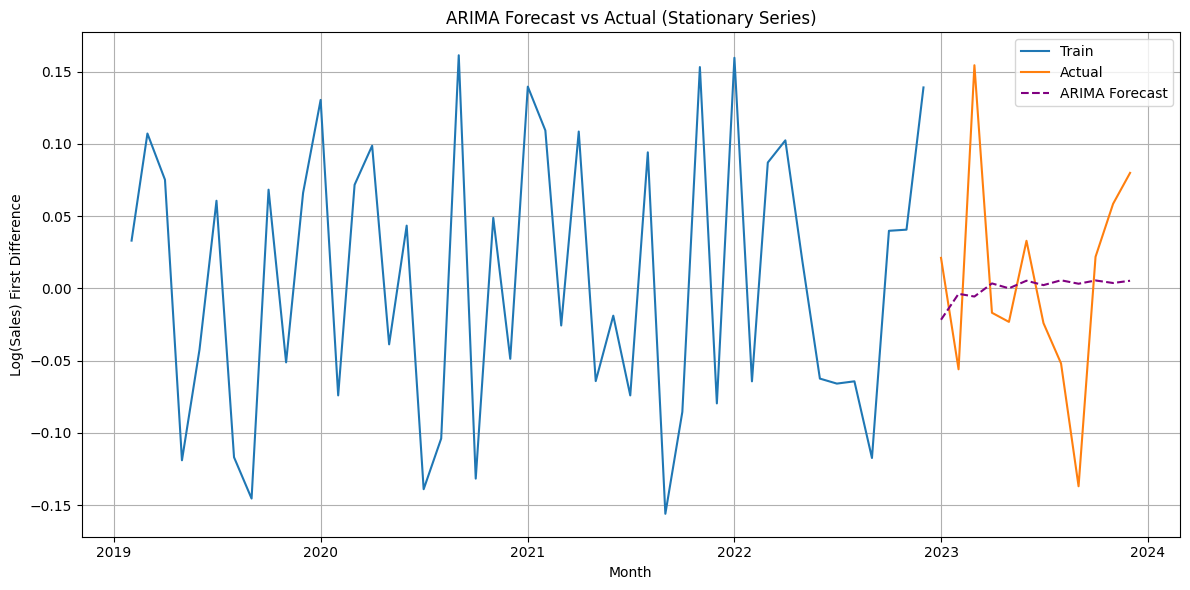

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(train['Log_Sales_Diff'], label='Train')
plt.plot(test['Log_Sales_Diff'], label='Actual')
plt.plot(arima_forecast, label='ARIMA Forecast', linestyle='--', color='purple')
plt.title("ARIMA Forecast vs Actual (Stationary Series)")
plt.xlabel("Month")
plt.ylabel("Log(Sales) First Difference")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Fit SARIMA Model


In [71]:
# Fit SARIMA model (manually chosen parameters as example)
sarima_model = SARIMAX(train['Log_Sales_Diff'],
                       order=(1, 0, 1),
                       seasonal_order=(1, 0, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit()


# Forecast
sarima_forecast = sarima_result.predict(start=test.index[0], end=test.index[-1])


### Model Evaluation

Evaluate using:
- RMSE (Root Mean Squared Error)
- MAPE (Mean Absolute Percentage Error)
- Visual comparison


In [73]:
sarima_rmse = np.sqrt(mean_squared_error(test['Log_Sales_Diff'], sarima_forecast))
sarima_mape = mean_absolute_percentage_error(test['Log_Sales_Diff'], sarima_forecast)

print(f"SARIMA RMSE: {sarima_rmse:.4f}")
print(f"SARIMA MAPE: {sarima_mape:.2%}")


SARIMA RMSE: 0.0763
SARIMA MAPE: 117.16%


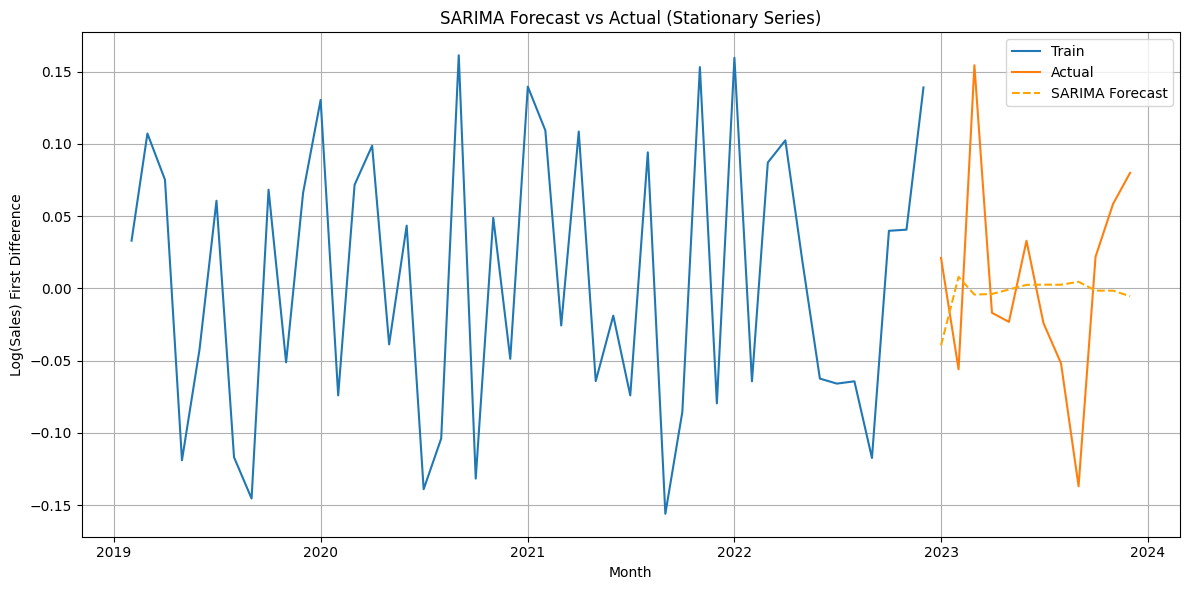

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(train['Log_Sales_Diff'], label='Train')
plt.plot(test['Log_Sales_Diff'], label='Actual')
plt.plot(sarima_forecast, label='SARIMA Forecast', linestyle='--', color='orange')
plt.title("SARIMA Forecast vs Actual (Stationary Series)")
plt.xlabel("Month")
plt.ylabel("Log(Sales) First Difference")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### ARIMA and SARIMA Comparison

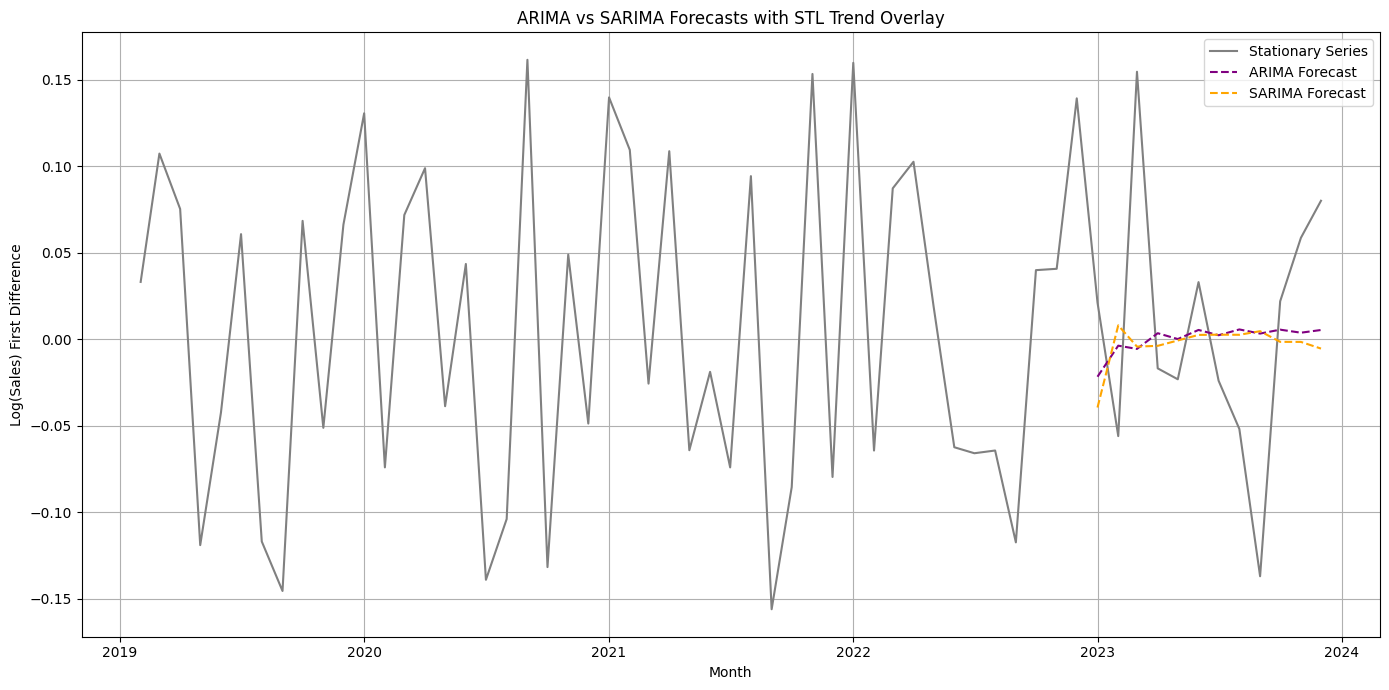

In [78]:
# Plot original sales, ARIMA and SARIMA forecasts on stationary scale
plt.figure(figsize=(14, 7))

plt.plot(df_stationary['Log_Sales_Diff'], label='Stationary Series', color='gray', linewidth=1.5)
plt.plot(arima_forecast, label='ARIMA Forecast', linestyle='--', color='purple')
plt.plot(sarima_forecast, label='SARIMA Forecast', linestyle='--', color='orange')

plt.title("ARIMA vs SARIMA Forecasts with STL Trend Overlay")
plt.xlabel("Month")
plt.ylabel("Log(Sales) First Difference")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Conclusion

- Successfully visualized and decomposed the time series.
- Identified clear seasonality and trend.
- SARIMA model provided a reasonable forecast with acceptable error metrics.
- This model can help businesses plan inventory and promotions more effectively.
